In [ ]:
import os
import numpy as np
import pandas as pd
import pwlf
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from typing import Tuple, Optional, Dict, Any, List
from tabulate import tabulate


# ===============================
#   UTILS: resampling, smoothing, outlier removal
# ===============================

def resample_data(x: np.ndarray, y: np.ndarray, num_points: int = 200, deg: int = 3) -> Tuple[np.ndarray, np.ndarray]:
    """
    Ricampionamento usando fit polinomiale di grado `deg`.
    Restituisce x_new (velocità) e y_new (segnale ricampionati).
    """
    x = np.array(x)
    y = np.array(y)
    if len(x) < deg + 1:
        # fallback: semplice interp lineare
        x_new = np.linspace(x.min(), x.max(), num_points)
        y_new = np.interp(x_new, x, y)
        return x_new, y_new

    coeffs = np.polyfit(x, y, deg)
    poly = np.poly1d(coeffs)
    x_new = np.linspace(x.min(), x.max(), num_points)
    y_new = poly(x_new)
    return x_new, y_new

def apply_savgol(data: np.ndarray, window_length: Optional[int] = None, polyorder: int = 3) -> np.ndarray:
    """
    Applica filtro Savitzky-Golay. Sceglie una finestra valida (dispari e <= len(data)).
    Se len(data) < 5, ritorna i dati non filtrati.
    """
    n = len(data)
    if n < 5:
        return data.copy()
    if window_length is None:
        # scegliere una finestra ~ 1/15 della lunghezza, almeno 5
        wl = max(5, int(np.floor(n / 15)))
    else:
        wl = int(window_length)
    # assicurarsi sia dispari
    if wl % 2 == 0:
        wl += 1
    if wl >= n:
        wl = n - 1 if (n - 1) % 2 == 1 else n - 2
    if wl < 3:
        wl = 3
    try:
        return savgol_filter(data, window_length=wl, polyorder=polyorder)
    except Exception:
        # fallback safety
        return data.copy()

def paired_iqr_outlier_removal(x: np.ndarray, y: np.ndarray, k: float = 1.5) -> Tuple[np.ndarray, np.ndarray]:
    """
    Rimuove coppie (x,y) dove y è outlier secondo IQR.
    Restituisce x_filtered, y_filtered (allineati).
    """
    y = np.array(y)
    x = np.array(x)
    if len(y) < 4:
        return x, y
    q1 = np.percentile(y, 25)
    q3 = np.percentile(y, 75)
    iqr = q3 - q1
    low = q1 - k * iqr
    high = q3 + k * iqr
    mask = (y >= low) & (y <= high) & np.isfinite(y)
    return x[mask], y[mask]



# ===============================
#   CALCOLO SOGLIA (generico per un segnale vs speed)
# ===============================

def calculate_threshold_piecewise(signal: np.ndarray,
                                  speed: np.ndarray,
                                  skip_first_point: bool = True,
                                  slope_change_required: Optional[float] = None,
                                  slope_direction: Optional[str] = None
                                  ) -> Tuple[Optional[float], Optional[float], Optional[int],
                                             Optional[Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]],
                                             Optional[str]]:
    """
    Calcola la soglia usando fit piecewise lineare con controllo sulla variazione di pendenza.
    - skip_first_point: scarta i primi 2 punti più lenti
    - slope_change_required: minimo delta di pendenza tra segmenti
    - slope_direction: 'increase' o 'decrease' per direzione attesa del cambio pendenza
    """
    try:
        sp_raw = np.array(speed, dtype=float)
        sig_raw = np.array(signal, dtype=float)

        # Ordinamento per velocità
        order = np.argsort(sp_raw)
        sp_raw = sp_raw[order]
        sig_raw = sig_raw[order]

        # Scarta primi 2 punti più lenti
        if skip_first_point and len(sp_raw) > 2:
            sp_raw = sp_raw[2:]
            sig_raw = sig_raw[2:]

        if len(sp_raw) < 6:
            return None, None, None, None, "Dati insufficienti per PWLF"

        # Fit piecewise lineare (2 segmenti → 1 breakpoint)
        pwlf_model = pwlf.PiecewiseLinFit(sp_raw, sig_raw)
        breaks = pwlf_model.fit(2)  # [start, breakpoint, end]

        sig_fit_breaks = pwlf_model.predict(breaks)
        sig_fit_line = sig_fit_breaks  # per plotting

        # Calcolo pendenze dei segmenti
        slopes = []
        for i in range(len(breaks)-1):
            x1, x2 = breaks[i], breaks[i+1]
            y1, y2 = sig_fit_breaks[i], sig_fit_breaks[i+1]
            slopes.append((y2 - y1) / (x2 - x1))

        # Controllo slope_change_required
        if slope_change_required is not None:
            delta_slope = abs(slopes[1] - slopes[0])
            if delta_slope < slope_change_required:
                return None, None, None, (sp_raw, sig_raw, breaks, sig_fit_line), \
                       f"Slope change {delta_slope:.3f} < required {slope_change_required}"

        # Controllo direzione slope_direction
        if slope_direction is not None:
            if slope_direction.lower() == 'increase' and not (slopes[1] > slopes[0]):
                return None, None, None, (sp_raw, sig_raw, breaks, sig_fit_line), \
                       f"Slope direction increase non rispettata"
            elif slope_direction.lower() == 'decrease' and not (slopes[1] < slopes[0]):
                return None, None, None, (sp_raw, sig_raw, breaks, sig_fit_line), \
                       f"Slope direction decrease non rispettata"

        # Soglia: breakpoint interno
        threshold_speed = breaks[1]
        threshold_signal = sig_fit_breaks[1]
        idx = int(np.argmin(np.abs(sp_raw - threshold_speed)))

        return threshold_signal, threshold_speed, idx, (sp_raw, sig_raw, breaks, sig_fit_line), None

    except Exception as e:
        return None, None, None, None, f"Errore fit PWLF: {e}"



def speed_to_pace(speed_kmh):
    """Converte km/h in stringa mm:ss/km"""
    if speed_kmh is None or speed_kmh <= 0:
        return "N/A"
    total_min = 60 / speed_kmh
    minutes = int(total_min)
    seconds = int(round((total_min - minutes) * 60))
    return f"{minutes}:{seconds:02d} min/km"


# ===============================
#   MAIN: validate_conconi 
# ===============================

def validate_conconi(summary_file: str,
                     base_path: str,
                     save_plots: bool = True,
                     plots_folder_name: str = "plots"):
    os.makedirs(os.path.join(base_path, plots_folder_name), exist_ok=True)
    df_summary = pd.read_excel(summary_file)
    results = []

    for _, row in df_summary.iterrows():
        if 'sport' in row and str(row['sport']).lower() != 'running':
            continue

        athlete_file = os.path.join(base_path, row['file'])
        print(f"\nProcessing {athlete_file}")

        try:
            df_data = pd.read_excel(athlete_file, sheet_name="Sheet2")
        except Exception as e:
            print(f"Errore file {athlete_file}: {e}")
            continue

        available_cols = list(df_data.columns)
        speed_col_candidates = ['Actual Power', 'Speed', 'Velocità', 'Velocity', 'speed']
        hr_col_candidates = ['HR', 'HeartRate', 'heart_rate', 'hr']
        lact_col_candidates = ['Bla', 'Lactate', 'Lact', 'bLa', 'bla']

        def pick_col(cands, cols):
            for c in cands:
                if c in cols:
                    return c
            return None

        speed_col = pick_col(speed_col_candidates, available_cols)
        hr_col = pick_col(hr_col_candidates, available_cols)
        lact_col = pick_col(lact_col_candidates, available_cols)

        if speed_col is None or hr_col is None or lact_col is None:
            print(f"[WARN] Colonne mancanti in {athlete_file}. Trovate: {available_cols}")
            continue

        sp = pd.to_numeric(df_data[speed_col], errors='coerce').dropna().values
        hr = pd.to_numeric(df_data[hr_col], errors='coerce').dropna().values
        lact = pd.to_numeric(df_data[lact_col], errors='coerce').dropna().values

        if len(sp) < 6 or len(hr) < 6 or len(lact) < 6:
            print(f"[WARN] Dati troppo pochi in {athlete_file}. sp:{len(sp)}, hr:{len(hr)}, lact:{len(lact)}")
            continue

        # HR-based PWLF
        est_hr_val, est_sp_hr, idx_hr, debug_hr, warn_hr = calculate_threshold_piecewise(
            signal=hr,
            speed=sp,
            skip_first_point=True,
            slope_change_required=0.20,
            slope_direction='decrease'
        )

        # LATTATO curve
        est_lact_val_auto, est_sp_lact_auto, idx_lact_auto, debug_lact, warn_lact = calculate_threshold_piecewise(
            signal=lact,
            speed=sp,
            skip_first_point=True,
            slope_change_required=0.30,
            slope_direction='increase'
        )



        est_sp_lact = est_sp_lact_auto
        est_lact_val = est_lact_val_auto

        # Calcolo HR interpolato alla velocità di soglia lattato (se possibile)
        hr_at_lact_speed = None
        hr_at_hr_speed = None
        if debug_hr is not None and est_sp_lact is not None:
            sp_hr_filt, hr_filt, hr_breaks, hr_fit_line = debug_hr
            try:
                pw = pwlf.PiecewiseLinFit(sp_hr_filt, hr_filt)
                pw.fit(2)
                hr_at_lact_speed = float(pw.predict([est_sp_lact])[0])
                hr_at_hr_speed = float(pw.predict([est_sp_hr])[0]) if est_sp_hr is not None else None

            except Exception:
                try:
                    hr_at_lact_speed = np.interp(est_sp_lact, sp_hr_filt, hr_fit_line)
                    hr_at_hr_speed = np.interp(est_sp_hr, sp_hr_filt, hr_fit_line) if est_sp_hr is not None else None
                except Exception:
                    hr_at_lact_speed, hr_at_hr_speed = None, None


        # Confronti (restano invariati)
        err_speed = None
        err_hr = None
        if (est_sp_hr is not None) and (est_sp_lact is not None):
            err_speed = est_sp_hr - est_sp_lact
            if (est_hr_val is not None) and (hr_at_lact_speed is not None):
                err_hr = est_hr_val - hr_at_lact_speed
            elif (hr_at_hr_speed is not None) and (hr_at_lact_speed is not None):
                err_hr = hr_at_hr_speed - hr_at_lact_speed

        print(f"\nStimato HR-based: {est_sp_hr} km/h ({speed_to_pace(est_sp_hr)}), val segnale: {est_hr_val}")

        # metriche e raccolta risultati (come prima)
        def speed_to_pace_sec(speed_kmh):
            if speed_kmh is None or speed_kmh <= 0:
                return np.nan
            return 3600 / speed_kmh

        pace_err_sec = None
        if (est_sp_hr is not None) and (est_sp_lact is not None):
            pace_err_sec = speed_to_pace_sec(est_sp_hr) - speed_to_pace_sec(est_sp_lact)

        results.append({
            "athlete_file": row['file'],
            "est_sp_hr": est_sp_hr,
            "est_hr_val": est_hr_val,
            "est_sp_lact": est_sp_lact,
            "est_lact_val": est_lact_val,
            "hr_at_lact_speed": hr_at_lact_speed,
            "err_sp_hr_minus_lact": err_speed,
            "err_hr_between_methods": err_hr,
            "err_pace_sec_per_km": pace_err_sec,
            "warn_hr": warn_hr,
            "warn_lact": warn_lact
        })

        # === Plot combinato e salvataggio ===
        if save_plots:
            try:
                plt.figure(figsize=(8, 5))
                ax1 = plt.gca()

                # --- HR-based (asse sinistro) ---
                if debug_hr is not None:
                    sp_hr_plot_raw, hr_plot_raw, hr_breaks, hr_fit_line = debug_hr
                    ax1.scatter(sp_hr_plot_raw, hr_plot_raw, marker='o', color='tab:red',
                                label='HR raw (usati PWLF)', alpha=0.6)


                    sp_raw, sig_raw, breaks, sig_fit_line = debug_hr
                    ax1.plot([hr_breaks[0], hr_breaks[1]], [hr_fit_line[0], hr_fit_line[1]], color='red', linewidth=2)
                    ax1.plot([hr_breaks[1], hr_breaks[2]], [hr_fit_line[1], hr_fit_line[2]], color='red', linewidth=2, label='Fit HR (PWLF)')


                if est_sp_hr is not None and est_hr_val is not None:
                    ax1.scatter(est_sp_hr, est_hr_val, marker='X', s=100,
                                label='Soglia HR-based', color='darkred', zorder=6)

                ax1.set_xlabel("Velocità (km/h)")
                ax1.set_ylabel("Frequenza cardiaca (bpm)", color='tab:red')
                ax1.tick_params(axis='y', colors='tab:red')

                # --- Lattato-based (asse destro) ---
                ax2 = ax1.twinx()
                if debug_lact is not None:
                    sp_lact_plot_raw, lact_plot_raw, lact_breaks, lact_fit_line = debug_lact
                    ax2.scatter(sp_lact_plot_raw, lact_plot_raw, marker='s', color='tab:blue',
                                label='Lattato raw (usati PWLF)', alpha=0.6)


                    sp_raw, sig_raw, breaks, sig_fit_line = debug_lact
                    ax2.plot([lact_breaks[0], lact_breaks[1]], [lact_fit_line[0], lact_fit_line[1]], color='blue', linewidth=2, linestyle='--')
                    ax2.plot([lact_breaks[1], lact_breaks[2]], [lact_fit_line[1], lact_fit_line[2]], color='blue', linewidth=2, linestyle='--', label='Fit Lattato (PWLF)')


                if est_sp_lact is not None and est_lact_val is not None:
                    ax2.scatter(est_sp_lact, est_lact_val, marker='D', s=100,
                                label='Soglia Lattato-based', color='navy', zorder=7)

                ax2.set_ylabel("Lattato (mmol/L)", color='tab:blue')
                ax2.tick_params(axis='y', colors='tab:blue')

                # HR interpolato alla velocità di soglia lattato (opzionale)
                if hr_at_lact_speed is not None and est_sp_lact is not None:
                    ax1.scatter(est_sp_lact, hr_at_lact_speed, marker='^', s=80,
                                label='HR @ soglia lattato', color='orange', zorder=7)

                # --- legende e layout ---
                handles1, labels1 = ax1.get_legend_handles_labels()
                handles2, labels2 = ax2.get_legend_handles_labels()
                ax1.legend(handles1 + handles2, labels1 + labels2, loc='best')

                plt.title(f"Soglie HR e Lattato — {row['file']}")
                plt.grid(True)
                plt.tight_layout()

                athlete_name = os.path.splitext(os.path.basename(row['file']))[0]
                plot_path = os.path.join(base_path, plots_folder_name, f"soglie_{athlete_name}.png")
                plt.savefig(plot_path, dpi=300)
                print(f"Plot salvato: {plot_path}")
                plt.close()

            except Exception as e:
                print(f"[WARN] Errore nel plotting di {athlete_file}: {e}")



    # --- metrics aggregation (invariata) ---
    df_results = pd.DataFrame(results)
    for c in ['est_sp_hr','est_sp_lact','est_hr_val','est_lact_val','hr_at_lact_speed','err_sp_hr_minus_lact','err_hr_between_methods', 'err_pace_sec_per_km']:
        if c in df_results.columns:
            df_results[c] = pd.to_numeric(df_results[c], errors='coerce')

    def safe_mae(s): s=s.dropna(); return np.mean(np.abs(s)) if len(s) else np.nan
    def safe_mdae(s): s=s.dropna(); return np.median(np.abs(s)) if len(s) else np.nan
    def safe_me(s): s=s.dropna(); return np.mean(s) if len(s) else np.nan
    def safe_mde(s): s=s.dropna(); return np.median(s) if len(s) else np.nan

    metrics = {
        "N_tests": int(df_results.dropna(subset=['est_sp_hr','est_sp_lact']).shape[0]),
        "MAE_speed_between_methods_kmh": safe_mae(df_results['err_sp_hr_minus_lact']),
        "MDAE_speed_between_methods_kmh": safe_mdae(df_results['err_sp_hr_minus_lact']),
        "ME_speed_between_methods_kmh": safe_me(df_results['err_sp_hr_minus_lact']),
        "MDE_speed_between_methods_kmh": safe_mde(df_results['err_sp_hr_minus_lact']),
        "MAE_hr_between_methods_bpm": safe_mae(df_results['err_hr_between_methods']),
        "MDAE_hr_between_methods_bpm": safe_mdae(df_results['err_hr_between_methods']),
        "ME_hr_between_methods_bpm": safe_me(df_results['err_hr_between_methods']),
        "MDE_hr_between_methods_bpm": safe_mde(df_results['err_hr_between_methods']),
        "MAE_pace_between_methods_sec_per_km": safe_mae(df_results['err_pace_sec_per_km']),
        "MDAE_pace_between_methods_sec_per_km": safe_mdae(df_results['err_pace_sec_per_km']),
        "ME_pace_between_methods_sec_per_km": safe_me(df_results['err_pace_sec_per_km']),
        "MDE_pace_between_methods_sec_per_km": safe_mde(df_results['err_pace_sec_per_km']),
    }

    return df_results, metrics





summary_file = r"C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\Data_Summary.xlsx"
base_path = r"C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data"
results_df, metrics = validate_conconi(summary_file, base_path, save_plots=True)



Processing C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\A1042.xlsx

Stimato HR-based: 20.999999999881613 km/h (2:51 min/km), val segnale: 178.17371601127275
Plot salvato: C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\plots\soglie_A1042.png

Processing C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\A1041.xlsx

Stimato HR-based: 15.348837207429938 km/h (3:55 min/km), val segnale: 160.48837207931388
Plot salvato: C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\plots\soglie_A1041.png

Processing C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\A104.xlsx

Stimato HR-based: None km/h (N/A), val segnale: None
Plot salvato: C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\plots\soglie_A104.png

Processing C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\A1038.xlsx

Stimato HR-based: 17.999999994615386 km/h (3:20 min/km), val segnale: 162.4090908775509
Plot sa

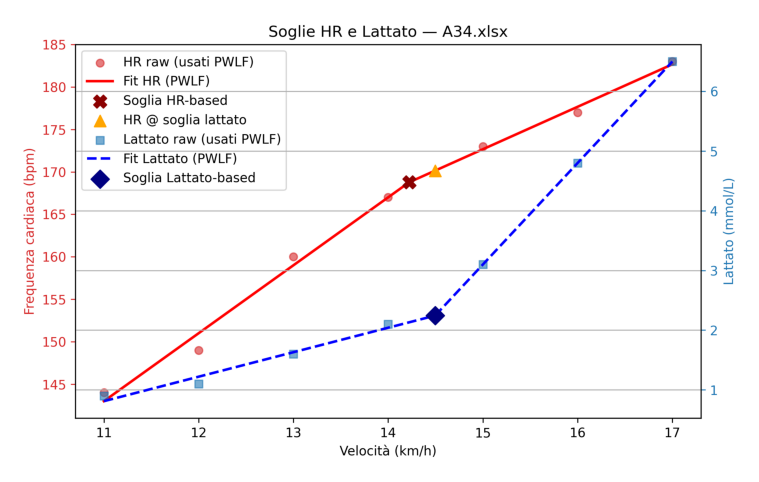

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Percorso dell'immagine salvata (modifica con il tuo file)
img_path = r"C:\Users\Dario\OneDrive\Desktop\PROGETTI\Test Conconi\data_v2\data\plots\soglie_A34.png"

# Lettura immagine
img = mpimg.imread(img_path)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(img)
plt.axis('off')  # disabilita assi
plt.show()


In [ ]:
print("\n== Metriche aggregate ==")
table = [(k, v) for k, v in metrics.items()]
print(tabulate(table, headers=["Metrica", "Valore"], tablefmt="fancy_grid", floatfmt=".3f"))




== Metriche aggregate ==
╒══════════════════════════════════════╤══════════╕
│ Metrica                              │   Valore │
╞══════════════════════════════════════╪══════════╡
│ N_tests                              │  234.000 │
├──────────────────────────────────────┼──────────┤
│ MAE_speed_between_methods_kmh        │    1.641 │
├──────────────────────────────────────┼──────────┤
│ MDAE_speed_between_methods_kmh       │    1.388 │
├──────────────────────────────────────┼──────────┤
│ ME_speed_between_methods_kmh         │   -1.216 │
├──────────────────────────────────────┼──────────┤
│ MDE_speed_between_methods_kmh        │   -1.320 │
├──────────────────────────────────────┼──────────┤
│ MAE_hr_between_methods_bpm           │    9.876 │
├──────────────────────────────────────┼──────────┤
│ MDAE_hr_between_methods_bpm          │    8.108 │
├──────────────────────────────────────┼──────────┤
│ ME_hr_between_methods_bpm            │   -6.016 │
├─────────────────────────────────────